In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import roc_curve, roc_auc_score

## Load the data

In [2]:
train_data_2008 = np.loadtxt('data/train_2008.csv', skiprows=1, delimiter=',')
X_test_2008 = np.loadtxt('data/test_2008.csv', skiprows=1, delimiter=',')

In [3]:
X_train_2008 = train_data_2008[:,:-1]
Y_train_2008 = train_data_2008[:,-1]

## Data pre-process

In [4]:
def normalize_data_column(x):
    '''
    normalize the input data such that it is centered around zero and has standard deviation of 1.0
    Inputs:
        x: a (N, D) shaped numpy array containing the data points.
    Outputs:
        xp: a (N, D) shaped numpy array containing the normalized data points.
    '''
    xp = np.zeros_like(x)
    
    for idx_D in range(len(x[0,:])): #normalize each column independently
        average = np.mean(x[:,idx_D])
        std_dev = np.std(x[:,idx_D])
        if std_dev > 0:
            xp[:,idx_D] = (x[:, idx_D] - average)/std_dev
        elif average != 0: #if all the elements are the same in that column, make all of them to be one
            xp[:,idx_D] = x[:, idx_D]/average
        else:
            xp[:,idx_D] = x[:, idx_D]
    
    return xp

In [5]:
#normalize each column of the data
X_train_2008 = normalize_data_column(X_train_2008)
X_test_2008 = normalize_data_column(X_test_2008)

In [6]:
#split the training data into training and validation dataset
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_2008, Y_train_2008, test_size=0.3)

## Build and train the model

In [21]:
model_parameter = "adaboost_lr0p1_lossSquare_nest1000_minsamplesplit4_maxdepth5"

In [22]:
#estimator for adaboost
ada_tree_estimator = DecisionTreeRegressor(min_samples_split=4, max_depth=5)#, max_features='sqrt', splitter='random')
#adaboost regressor
ab = AdaBoostRegressor(ada_tree_estimator, learning_rate=0.1, loss='square', n_estimators=1000)
#fit
ab.fit(X_train, Y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=0.1, loss='square', n_estimators=1000,
         random_state=None)

## Validation

In [23]:
def visualize_loss_curves(model, X_train, Y_train, X_test, Y_test, cut):
    plt.close('all')

    Y_train_pred = np.zeros_like(Y_train)
    Y_test_pred = np.zeros_like(Y_test)
    losses_train = []
    losses_test = []

    # For each added classifier, store the new training and test losses.
    for clf in model.estimators_:
        Y_train_pred += clf.predict(X_train)
        Y_test_pred += clf.predict(X_test)
        #make the cut and take the sign
        Y_train_pred_sign = np.where(Y_train_pred > cut, 1, 0)
        Y_test_pred_sign = np.where(Y_test_pred > cut, 1, 0)
        
        losses_train.append(len(np.where(Y_train_pred_sign != Y_train)[0]) / len(Y_train_pred))
        losses_test.append(len(np.where(Y_test_pred_sign != Y_test)[0]) / len(Y_test_pred))

    # Plot the losses across n_clfs.
    n_clfs = len(model.estimators_)
    plt.plot(np.arange(1, n_clfs + 1), losses_train)
    plt.plot(np.arange(1, n_clfs + 1), losses_test)
    plt.title('Loss vs. n_clfs')
    plt.legend(['Training loss', 'Test loss'])
    plt.xlabel('n_clfs')
    plt.ylabel('Loss')
    plt.show()

In [24]:
def compute_efficiency(Y_predict, cut, Y_test):
    total = (Y_test).sum()
    passing = ((Y_predict > cut) * Y_test).sum() # gives signal and passing cuts
    return passing * 1.0 / total

In [25]:
## find the best cut
Y_train_predict = ab.predict(X_train)
Y_valid_predict = ab.predict(X_valid)
cuts1 = np.arange(0, 0.1, 0.00005)
cuts2 = np.arange(0.1, 0.9, 0.001)
cuts3 = np.arange(0.9, 1, 0.00005)
cuts = np.concatenate([cuts1, cuts2, cuts3])
# write cuts and efficiency to file
with open('roc_cut_eff.txt', 'w') as textfile:
    textfile.write("cut, efficiency_sig, efficiency_bkg \n")
    for cut in cuts:
        efficiency_sig = compute_efficiency(Y_valid_predict, cut, Y_valid) # compute efficiency at each cut point
        efficiency_bkg = compute_efficiency(Y_valid_predict, cut, 1-Y_valid) # compute efficiency at each cut point
        line = "{},{},{}\n".format(cut, efficiency_sig, efficiency_bkg)
        textfile.write(line) # save cut and efficiency to file

In [26]:
#visualize_loss_curves(ab, X_train, Y_train, X_valid, Y_valid, 0.405)

In [27]:
## calculate the AUC - area under the curve
AUC_train = roc_auc_score(Y_train, Y_train_predict)
print(AUC_train)
AUC_valid = roc_auc_score(Y_valid, Y_valid_predict)
print(AUC_valid)

0.829344504925777
0.7527468296348847


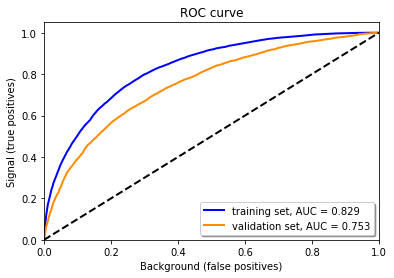

In [28]:
## draw the ROC curve
fpr_train, tpr_train, _ = roc_curve(Y_train, Y_train_predict)
fpr_valid, tpr_valid, _ = roc_curve(Y_valid, Y_valid_predict)
plt.figure()
lw = 2
plt.plot(fpr_train, tpr_train, color='blue',
         lw=lw, label='training set, AUC = %.3f'%AUC_train)
plt.plot(fpr_valid, tpr_valid, color='darkorange',
         lw=lw, label='validation set, AUC = %.3f'%AUC_valid)
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background (false positives)')
plt.ylabel('Signal (true positives)')
plt.legend(loc=0, shadow=True)
plt.title(r'ROC curve')
plt.savefig('plots/ROC_'+model_parameter+'.pdf')

## Make the prediction!

In [29]:
predict_test_2008 = ab.predict(X_test_2008)

## Write to submission file

In [30]:
ids_2008 = np.arange(len(X_test_2008))
target_2008 = np.copy(predict_test_2008)

In [31]:
subm_2008 = np.stack([ids_2008,target_2008], axis=1)
#let's name the submission file in this way
#submission_2008or2012_date_version_algorithm_person.csv
np.savetxt('submission/submission_2008_02102019_v2_'+model_parameter+'_Zhicai.csv', subm_2008, fmt='%d,%.6f', header='id,target', comments='')